In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16, ResNet50, vgg16, resnet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Resizing
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
import keras.backend as K
import math
import os
import cv2
from enum import Enum
from random import sample

In [16]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Params

In [17]:
IMG_HEIGHT = 480
IMG_WIDTH = 640

ML_MAP_HEIGHT = int(math.ceil(IMG_HEIGHT / 8))
ML_MAP_WIDTH = int(math.ceil(IMG_WIDTH / 8))

TRAIN_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/train'
TRAIN_MAP_PATH = '/content/gdrive/MyDrive/salicon/maps/train'
VAL_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/val'
VAL_MAP_PATH = '/content/gdrive/MyDrive/salicon/maps/val'
TEST_IMG_PATH = '/content/gdrive/MyDrive/salicon/images/test'

# Custom data generator

In [ ]:
class MLNetDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, size):
      datas = [f for f in os.listdir(data)]
      labeles = [f for f in os.listdir(labels)]
      datas.sort()
      labeles.sort()
      self.images = [data + "/" + f for f in datas[:size]]
      self.maps = [labels + "/" + f for f in labeles[:size]]

      self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        x = []
        y = []
        for f in self.images[start:end]:
          image = cv2.imread(f)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = tf.keras.applications.vgg19.preprocess_input(image)
          x.append(image)

        for f in self.maps[start:end]:
          image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
          y.append(image.astype('float32') / 255)

        return np.array(x), np.array(y)

# Prior mask layer

In [2]:
class EltWiseProduct(Layer):
    def __init__(self, downsampling_factor=10, init='glorot_uniform', activation='linear',
                 weights=None, W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.downsampling_factor = downsampling_factor
        self.init = initializers.get(init)
        self.activation = activation
        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.input_dim = input_dim

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)

        self.input_spec = InputSpec(ndim=4)
        super(EltWiseProduct, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_shape = (ML_MAP_HEIGHT, ML_MAP_WIDTH, 1)   # Adjusted weight shape for broadcasting
        self.W = self.add_weight(shape=self.W_shape,
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None,) + input_shape[1:])
        self.built = True

    def call(self, x, mask=None):
        output = x * tf.expand_dims(1 + self.W, 0)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'downsampling_factor': self.downsampling_factor,
            'init': initializers.serialize(self.init),
            'activation': self.activation,
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'input_dim': self.input_dim
        }
        base_config = super(EltWiseProduct, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Custom loss function

In [4]:
def mlnet_loss(y_true, y_pred):
  max_y = K.max(K.max(y_pred, axis=1), axis=1)  # Adjust axis values
  max_y = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(max_y, axis=-1), IMG_HEIGHT, axis=-1)), IMG_WIDTH, axis=-1)
  return K.mean(K.square((y_pred / max_y) - y_true) / (1.1 - y_true))

# Model

In [18]:
MODEL_PATH = '/content/gdrive/MyDrive/salicon'
model = tf.keras.models.load_model(f'{MODEL_PATH}/mlnet-bigger_prior-29-0.03.hdf5', custom_objects={"EltWiseProduct":EltWiseProduct, 'loss': mlnet_loss})
model.summary()

Model: "mlnet-vgg19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 120, 160, 256)        2325568   ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 60, 80, 256)          0         ['sequential[0][0]']          
 D)                                                                                               
                                                                                                  
 sequential_1 (Sequential)   (None, None, None, 512)      8259584   ['max_pooling2d[0][0

# Some examples of model prediction

In [22]:
# Helper function for showing results
def show_image(image_path, model, saliency_map_path = None):
    image = plt.imread(image_path)
    img_vgg19 = tf.keras.applications.vgg19.preprocess_input(image)
    predicted = model(img_vgg19.reshape(1,480,640,3)).numpy().reshape(480,640,1)

    fig, axes = plt.subplots(1, 3 if saliency_map_path is not None else 2, figsize=(8, 4))

    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(predicted, cmap='gray')
    axes[1].set_title('Predicted')
    axes[1].axis('off')

    if saliency_map_path:
      saliency_map = plt.imread(saliency_map_path)
      axes[2].imshow(saliency_map, cmap='gray')
      axes[2].set_title('Ground truth')
      axes[2].axis('off')

    plt.show()

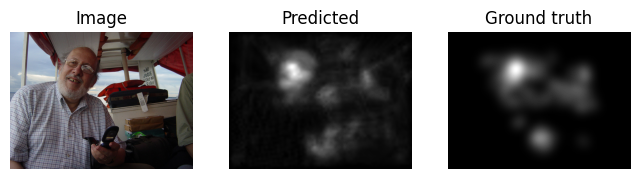

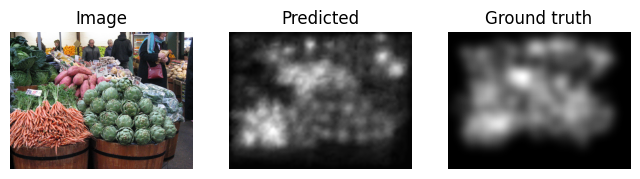

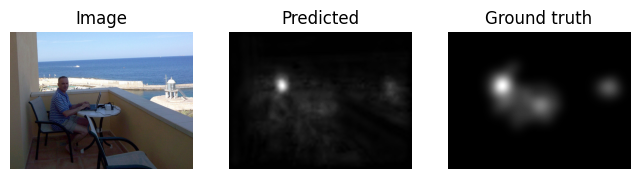

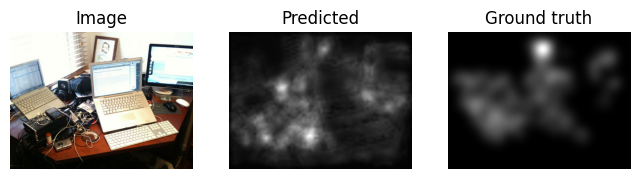

In [23]:
imgs = [f.replace('.jpg', '') for f in sample(os.listdir(VAL_IMG_PATH), 4)]
for img in imgs:
  show_image(
    f'{VAL_IMG_PATH}/{img}.jpg',
    model,
    f'{VAL_MAP_PATH}/{img}.png'
  )

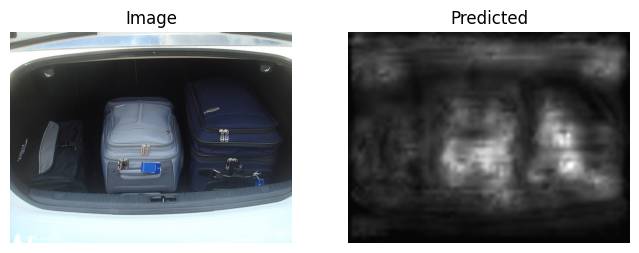

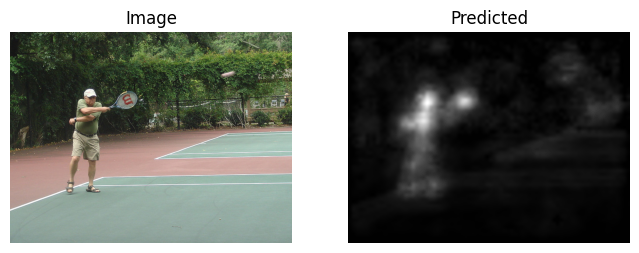

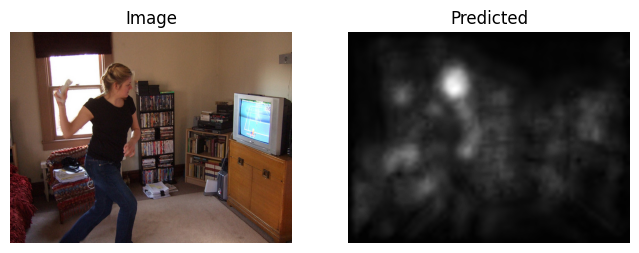

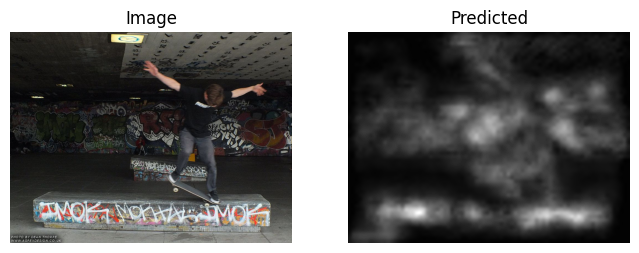

In [24]:
imgs = [f.replace('.jpg', '') for f in sample(os.listdir(TEST_IMG_PATH), 4)]
for img in imgs:
  show_image(
    f'{TEST_IMG_PATH}/{img}.jpg',
    model
  )